# Assessment 1: Rule-Based AI for Credit Risk Classification

## 1. Importing Relevant Libraries    
Importing all the relevant libraries needed for this rule-based AI task.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Data Loading and Preparation
Here, we load the pre-split training and testing datasets. We also perform minor cleaning, such as renaming columns for easier access and removing any unnecessary index columns.

In [2]:
try:
    full_df = pd.read_csv('credit_risk_data.csv')
except FileNotFoundError:
    print("Error: Make sure 'credit_risk_data.csv' is in the correct directory.")
    raise

# Handle missing values in the 'Risk'
full_df.dropna(subset=['Risk'], inplace=True)

# Fill blank 'Saving accounts' and 'Checking account' cells with the string 'unknown'
full_df['Saving accounts'] = full_df['Saving accounts'].fillna('unknown')
full_df['Checking account'] = full_df['Checking account'].fillna('unknown')

for df in [full_df]:
    df.rename(columns={
        'Age': 'age',
        'Sex': 'sex',
        'Jobs': 'jobs',
        'Housing': 'housing',
        'Saving accounts': 'saving_accounts',
        'Checking account': 'checking_account',
        'Credit amount': 'credit_amount',
        'Duration': 'duration',
        'Purpose': 'purpose'
    }, inplace=True)
    if 'Unnamed: 0' in df.columns:
        full_df.drop('Unnamed: 0', axis=1, inplace=True)

x_train = full_df.drop('Risk', axis=1)
y_train = full_df['Risk']

# Split the data into training and testing sets (80% train, 20% test)
# This function creates x_train, x_test, y_train, and y_test all at once
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training set shape: (896, 10)
Testing set shape: (224, 10)
Training labels shape: (896,)
Testing labels shape: (224,)


## 3. Rule-Based Classifier Class
This cell contains the core `CreditRiskClassifier` class. This class encompasses the logic for the rule-based system, including methods to add rules (the Knowledge Base) and make predictions (the Inference Engine).

In [3]:
class CreditRiskClassifier:
    def __init__(self, default_prediction='good'):
        self.rules = []
        self.default_prediction = default_prediction

    def add_rule(self, conditions, outcome):
        self.rules.append({'conditions': conditions, 'outcome': outcome})

    def apply_rules_to_row(self, row):
        # Applies the stored rules to a single row of data (one applicant).
        for rule in self.rules:
            match = True
            # Iterate through each condition in the rule (For example: 'age' and 'housing')
            for feature, condition in rule['conditions'].items():
                actual_value = row[feature]

                # Check if the condition is a tuple for range checking
                if isinstance(condition, tuple) and len(condition) == 2:
                    operator, value = condition
                    if operator == '>':
                        if not (actual_value > value): match = False
                    elif operator == '<':
                        if not (actual_value < value): match = False
                    elif operator == '>=':
                        if not (actual_value >= value): match = False
                    elif operator == '<=':
                        if not (actual_value <= value): match = False
                    else:
                        # Unrecognized operator
                        match = False
                
                # Fallback to the original exact match for strings or single numbers
                else:
                    if actual_value != condition:
                        match = False

                # If any condition in the rule fails, stop checking this rule
                if not match:
                    break
            
            # If all conditions in the rule passed, return the outcome
            if match:
                return rule['outcome']
        
        # If no rules matched, return the default prediction
        return self.default_prediction

    def predict(self, X):
        # Makes predictions for a whole dataset.
        return X.apply(self.apply_rules_to_row, axis=1).tolist()
        

## 4. Model Configuration and Rule Definition
Now we create three distinct instances of our classifier. Each instance represents one of our experimental models (Comprehensive, Financial, and Demographic). We then populate each model with its specific set of rules.

In [4]:
# ==============================================================================
# Model A: Comprehensive Baseline
# This model combines financial and demographic data for nuanced decisions.
# ==============================================================================
clf_A = CreditRiskClassifier(default_prediction='good')

# ----- High-Risk Rules (Comprehensive) -----
# Young, renting, little savings, and a large loan is a classic high-risk profile.
clf_A.add_rule({'saving_accounts': 'little', 'credit_amount': ('>', 4000)}, 'bad')
# A large loan taken over a very long period.
clf_A.add_rule({'credit_amount': ('>', 6000), 'duration': ('>', 36)}, 'bad')
# Low savings and low checking account balance suggests poor financial health.
clf_A.add_rule({'saving_accounts': 'little', 'checking_account': 'little'}, 'bad')
# A young, unskilled worker who rents their home is a high risk.
clf_A.add_rule({'age': ('<', 25), 'jobs': 0, 'housing': 'rent'}, 'bad')
# A non-essential loan for someone who is renting.
clf_A.add_rule({'housing': 'rent', 'purpose': 'furniture/equipment'}, 'bad')
# Unskilled status alone is a significant risk factor.
clf_A.add_rule({'jobs': 0}, 'bad')


# ----- Low-Risk Rules (Comprehensive) -----
# Someone with rich savings is almost always a good risk.
clf_A.add_rule({'saving_accounts': 'rich'}, 'good')
# A small, short-term loan is very low risk.
clf_A.add_rule({'credit_amount': ('<', 1500), 'duration': ('<=', 12)}, 'good')
# Moderate savings and a reasonable checking balance is a good sign.
clf_A.add_rule({'saving_accounts': 'moderate', 'checking_account': 'moderate'}, 'good')
# An older, skilled worker who owns their home represents stability.
clf_A.add_rule({'age': ('>', 40), 'jobs': ('>=', 1), 'housing': 'own'}, 'good')
# A loan for a productive purpose like 'business' or 'education' is generally safer.
clf_A.add_rule({'purpose': 'business'}, 'good')
clf_A.add_rule({'purpose': 'education'}, 'good')
# Owning a home is a strong indicator of stability.
clf_A.add_rule({'housing': 'own'}, 'good')


# ==============================================================================
# Model B: Financial Focus
# This model makes decisions based only on the applicant's financial situation.
# ==============================================================================
clf_B = CreditRiskClassifier(default_prediction='good')

# ----- High-Risk Rules (Financial) -----
# Very little savings combined with a moderate-to-high loan amount.
clf_B.add_rule({'saving_accounts': 'little', 'credit_amount': ('>', 4000)}, 'bad')
# A large loan taken over a very long period.
clf_B.add_rule({'credit_amount': ('>', 6000), 'duration': ('>', 36)}, 'bad')
# Low savings and low checking account balance suggests poor financial health.
clf_B.add_rule({'saving_accounts': 'little', 'checking_account': 'little'}, 'bad')

# ----- Low-Risk Rules (Financial) -----
# Someone with rich savings is almost always a good risk.
clf_B.add_rule({'saving_accounts': 'rich'}, 'good')
# A small, short-term loan is very low risk.
clf_B.add_rule({'credit_amount': ('<', 1500), 'duration': ('<=', 12)}, 'good')
# Moderate savings and a reasonable checking balance is a good sign.
clf_B.add_rule({'saving_accounts': 'moderate', 'checking_account': 'moderate'}, 'good')


# ==============================================================================
# Model C: Demographic Focus
# This model uses only personal information to predict risk.
# ==============================================================================
clf_C = CreditRiskClassifier(default_prediction='good')

# ----- High-Risk Rules (Demographic) -----
# A young, unskilled worker who rents their home is a high risk.
clf_C.add_rule({'age': ('<', 25), 'jobs': 0, 'housing': 'rent'}, 'bad')
# A non-essential loan for someone who is renting.
clf_C.add_rule({'housing': 'rent', 'purpose': 'furniture/equipment'}, 'bad')
# Unskilled status alone is a significant risk factor.
clf_C.add_rule({'jobs': 0}, 'bad')

# ----- Low-Risk Rules (Demographic) -----
# An older, skilled worker who owns their home represents stability.
clf_C.add_rule({'age': ('>', 40), 'jobs': ('>=', 1), 'housing': 'own'}, 'good')
# A loan for a productive purpose like 'business' or 'education' is generally safer.
clf_C.add_rule({'purpose': 'business'}, 'good')
clf_C.add_rule({'purpose': 'education'}, 'good')
# Owning a home is a strong indicator of stability.
clf_C.add_rule({'housing': 'own'}, 'good')

## 5. Evaluation Function
This helper function takes a classifier and test data, then calculates and visualizes its performance.

In [5]:
def evaluate_model(name, classifier, X_test, y_test):
    #Calculates, prints, and visualises the performance metrics for a given classifier.
    #Returns a dictionary containing the key metrics.
    print(f"----- Evaluating: {name} -----")
    
    # Get the model's predictions for the test set.
    y_pred = classifier.predict(X_test)
    
    # Calculate key performance metrics using scikit-learn.
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='bad', zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label='bad', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='bad', zero_division=0)
    
    # Print the calculated metrics.
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (for 'bad' risk): {precision:.4f}")
    print(f"Recall (for 'bad' risk): {recall:.4f}")
    print(f"F1-Score (for 'bad' risk): {f1:.4f}\n")
    
    # Generate and display a confusion matrix heatmap.
    cm = confusion_matrix(y_test, y_pred, labels=['good', 'bad'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Good', 'Predicted Bad'], 
                yticklabels=['Actual Good', 'Actual Bad'])
    plt.title(f'Confusion Matrix for {name}')
    plt.savefig(f"{name} Confusion Matrix.pdf", format="pdf")
    plt.show()

    # Return the metrics for later use (e.g., in a comparison chart).
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

## 6. Run Experiment and Analyze Results
Finally, we run the evaluation for each of our three configured models on the unseen test data. The output below will form the basis of the 'Result Analysis and Discussion' section of the scientific paper.

----- Evaluating: Model A (Comprehensive) -----
Accuracy: 0.6116
Precision (for 'bad' risk): 0.6147
Recall (for 'bad' risk): 0.5982
F1-Score (for 'bad' risk): 0.6063



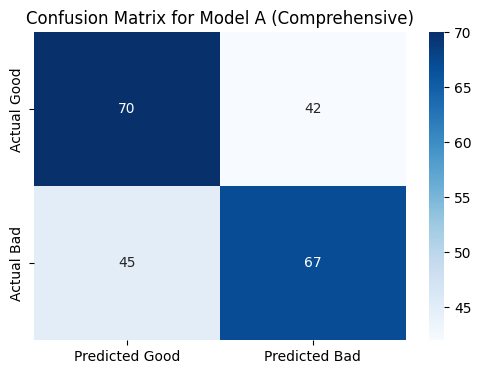

----- Evaluating: Model B (Financial Focus) -----
Accuracy: 0.6339
Precision (for 'bad' risk): 0.6500
Recall (for 'bad' risk): 0.5804
F1-Score (for 'bad' risk): 0.6132



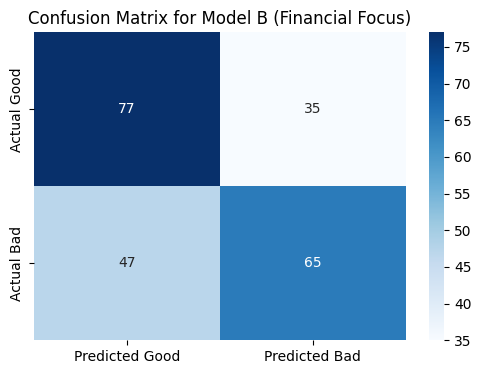

----- Evaluating: Model C (Demographic Focus) -----
Accuracy: 0.4821
Precision (for 'bad' risk): 0.3571
Recall (for 'bad' risk): 0.0446
F1-Score (for 'bad' risk): 0.0794



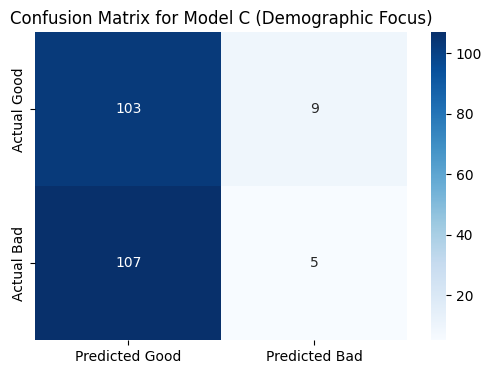


----- Model Accuracy Comparison Chart -----



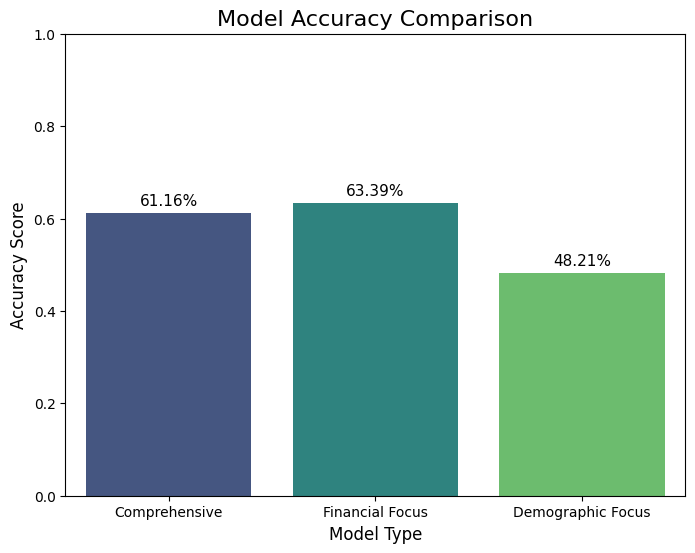

In [6]:
# Run the evaluation for each model and store the returned dictionaries
results_A = evaluate_model("Model A (Comprehensive)", clf_A, x_test, y_test)
results_B = evaluate_model("Model B (Financial Focus)", clf_B, x_test, y_test)
results_C = evaluate_model("Model C (Demographic Focus)", clf_C, x_test, y_test)

# Create a dictionary to hold the accuracy of each model
model_accuracies = {
    'Comprehensive': results_A['accuracy'],
    'Financial Focus': results_B['accuracy'],
    'Demographic Focus': results_C['accuracy']
}

# Prepare data for plotting
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

print("\n----- Model Accuracy Comparison Chart -----\n")

# Create the bar plot
plt.figure(figsize=(8, 6))

# The corrected line with hue and legend=False
barplot = sns.barplot(x=models, y=accuracies, hue=models, palette='viridis', legend=False)

# Add labels and title
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylim(0, 1.0) # Set y-axis to be from 0 to 1 for percentage representation

# Add the accuracy values on top of the bars
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.01, f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=11)

# Display the plot
plt.savefig(f"Model Accuracy Comparison Graph.pdf", format="pdf")  
plt.show()